<a href="https://colab.research.google.com/github/dimLMT/Metabolic-Syndrome-Forecast/blob/main/part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
 # Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Sklearn Display
from sklearn import set_config
set_config(transform_output='pandas')
# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [14]:
import joblib
# Confirm the file was saved by loading it back in
loaded = joblib.load('/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week17/Data/part1.joblib')
loaded.keys()

dict_keys(['X_train_tf', 'y_train', 'X_test_tf', 'y_test', 'model', 'permutation_importances', 'X', 'y'])

In [15]:
# Loading data and objects in a new notebook
X_train_tf = loaded['X_train_tf']
y_train = loaded['y_train']
X_test_tf = loaded['X_test_tf']
y_test = loaded['y_test']
model = loaded['model']
permutation_importances = loaded['permutation_importances']
X = loaded['X']
y = loaded['y']

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues',cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train': results_train,
                    'test': results_test}
    return results_dict

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.99      1.00      0.99       616
   No MetSyn       1.00      0.99      1.00      1184

    accuracy                           1.00      1800
   macro avg       0.99      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



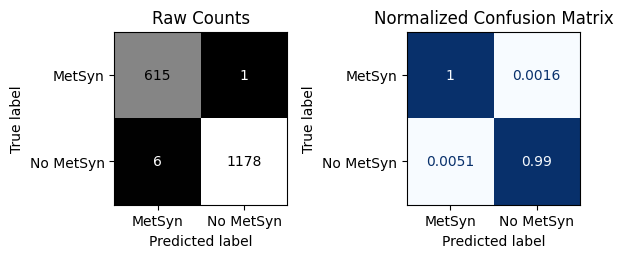

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.76      0.86      0.81       206
   No MetSyn       0.92      0.86      0.89       395

    accuracy                           0.86       601
   macro avg       0.84      0.86      0.85       601
weighted avg       0.87      0.86      0.86       601



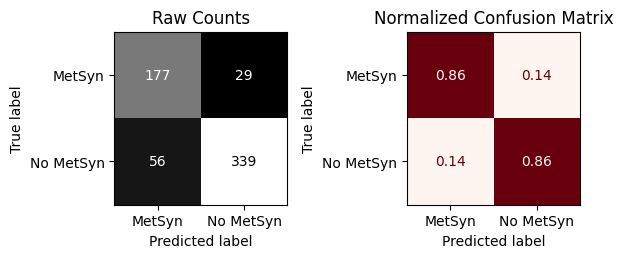

In [17]:
# restore last used model
results = evaluate_classification(model, X_train_tf, y_train, X_test_tf, y_test)

In [18]:
pd.set_option('display.max_columns', None)
X_train_tf.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Female,Sex_Male,Marital_Divorced,Marital_Married,Marital_Missing,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
seqn,,,,,,,,,,,,,,,,,,,,,,,,
69151,0.479889,1.524161,-0.154930,-0.346375,-0.369369,-0.151810,-0.465579,0.215100,0.615647,-0.589530,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70567,1.789367,-0.898446,0.210650,-0.528455,1.988308,0.035267,0.783160,-0.426943,-0.824293,-0.047159,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
64333,-0.146383,-0.736939,-0.741118,-0.331201,-0.369369,-0.158786,-1.159324,-0.175709,0.353840,0.517349,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
68115,1.789367,-0.736939,-0.835665,-0.437415,-0.369369,-0.051190,1.199407,0.550078,0.092033,-0.091434,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
67719,-0.772656,1.265750,-0.993242,-0.604322,4.345986,2.238468,1.130032,-1.934347,1.008358,-0.157847,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
X_train_tf= X_train_tf.rename({'Sex_Female':'Is_Female'}, axis=1)
X_train_tf= X_train_tf.drop(['Sex_Male'], axis=1)
X_test_tf= X_test_tf.rename({'Sex_Female':'Is_Female'}, axis=1)
X_test_tf= X_test_tf.drop(['Sex_Male'], axis=1)
X_test_tf.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Is_Female,Marital_Divorced,Marital_Married,Marital_Missing,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
seqn,,,,,,,,,,,,,,,,,,,,,,,
71097,-1.569729,-1.286064,-1.440762,-0.740883,-0.369369,-0.111308,-0.743077,-0.454858,0.419292,-0.545254,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
63684,0.309088,-0.252418,0.109800,0.032960,-0.369369,-0.114944,-0.118707,-0.008219,0.288388,-0.523117,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
67939,1.333897,1.524161,-0.287295,-0.589149,-0.369369,-0.158786,-0.604328,0.270930,2.513749,-0.246397,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
67195,0.024418,0.361309,0.248468,0.154347,-0.369369,-0.153248,-0.188082,-0.371113,-0.235226,-0.700217,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70058,-0.601854,-0.252418,-1.465975,-1.180911,-0.369369,-0.154431,0.158790,-0.036134,0.222936,-0.556323,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Using PCA to speed up learning and reduce dimensionality

In [20]:
from sklearn.decomposition import PCA
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
X_train_tf_scaled = scaler.fit_transform(X_train_tf)
X_test_tf_scaled = scaler.transform(X_test_tf)

In [21]:
# Define PCA to address 85% of the variance
pca85 = PCA(n_components=.85)
# fit and transform on training data
X_train_pca85 = pca85.fit_transform(X_train_tf_scaled)
# transform test data
X_test_pca85 = pca85.transform(X_test_tf_scaled)
# obtain the number of PCs used
pca85.n_components_

14

In [22]:
from sklearn.ensemble import BaggingClassifier
# Instantiate a default Bagged Tree model
bagtree = BaggingClassifier(random_state = 42)
# Fit the model pipeline on the training data only
bagtree.fit(X_train_pca85, y_train)

BaggingClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.97      1.00      0.98       616
   No MetSyn       1.00      0.99      0.99      1184

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



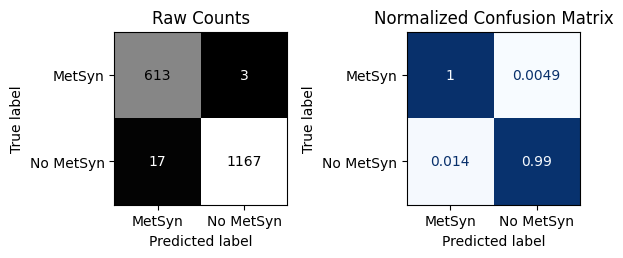

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.69      0.77      0.72       206
   No MetSyn       0.87      0.82      0.84       395

    accuracy                           0.80       601
   macro avg       0.78      0.79      0.78       601
weighted avg       0.81      0.80      0.80       601



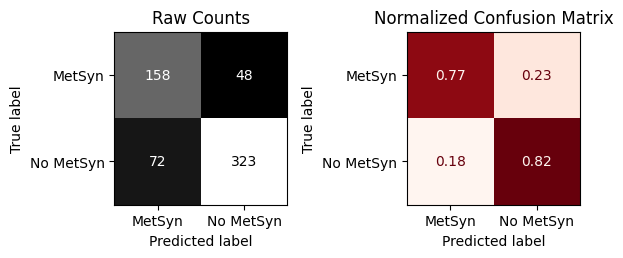

In [23]:
# Test the function
results = evaluate_classification(bagtree,X_train_pca85, y_train, X_test_pca85, y_test)

In [24]:
pca85.explained_variance_ratio_

array([0.12632425, 0.09097926, 0.08080248, 0.06812303, 0.06396268,
       0.05981434, 0.05170384, 0.04989629, 0.04763263, 0.04697875,
       0.0447895 , 0.04365233, 0.04044139, 0.03787827])

In [27]:
# to keep only 3 principal components
pca = PCA(n_components=3)
# fit and transform on training data
X_train_pca3 = pca.fit_transform(X_train_tf_scaled)
# transform test data
X_test_pca3 = pca.transform(X_test_tf_scaled)

In [34]:
#combine these PC’s with the original features
sum_scaled_train=pd.merge(X_train_tf_scaled,X_train_pca3,on='seqn')
sum_scaled_test=pd.merge(X_test_tf_scaled,X_test_pca3,on='seqn')

### Apply Clustering to predict

In [35]:
X=pd.concat([X_train_tf_scaled, X_test_tf_scaled])
sum_X=pd.concat([sum_scaled_train, sum_scaled_test])

In [37]:
from sklearn.cluster import KMeans
# Instantiate KMeans for 2 clusters
kmeans = KMeans(n_clusters = 2, n_init = 'auto', random_state = 42)
kmeans.fit(X)
# Save the cluster labels to the dataframe
sum_X['cluster'] = kmeans.labels_
sum_X.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Is_Female,Marital_Divorced,Marital_Married,Marital_Missing,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White,pca0,pca1,pca2,cluster
seqn,,,,,,,,,,,,,,,,,,,,,,,,,,,
69151,0.479889,1.524161,-0.154930,-0.346375,-0.369369,-0.151810,-0.465579,0.215100,0.615647,-0.589530,-1.015678,-0.335387,0.996672,-0.299313,-0.208514,-0.509531,-0.268452,-0.417335,-0.550821,-0.352558,-0.334361,-0.15644,1.266855,-0.386316,-2.105334,0.324743,1
70567,1.789367,-0.898446,0.210650,-0.528455,1.988308,0.035267,0.783160,-0.426943,-0.824293,-0.047159,-1.015678,-0.335387,0.996672,-0.299313,-0.208514,-0.509531,-0.268452,-0.417335,-0.550821,-0.352558,-0.334361,-0.15644,1.266855,1.563947,-1.543086,1.073561,0
64333,-0.146383,-0.736939,-0.741118,-0.331201,-0.369369,-0.158786,-1.159324,-0.175709,0.353840,0.517349,-1.015678,2.981629,-1.003339,-0.299313,-0.208514,-0.509531,-0.268452,2.396158,-0.550821,-0.352558,-0.334361,-0.15644,-0.789357,-1.027447,0.106546,-0.070229,1
68115,1.789367,-0.736939,-0.835665,-0.437415,-0.369369,-0.051190,1.199407,0.550078,0.092033,-0.091434,0.984564,-0.335387,-1.003339,-0.299313,-0.208514,-0.509531,3.725055,-0.417335,-0.550821,-0.352558,-0.334361,-0.15644,1.266855,0.545917,0.071265,2.486408,0
67719,-0.772656,1.265750,-0.993242,-0.604322,4.345986,2.238468,1.130032,-1.934347,1.008358,-0.157847,-1.015678,-0.335387,0.996672,-0.299313,-0.208514,-0.509531,-0.268452,-0.417335,1.815473,-0.352558,-0.334361,-0.15644,-0.789357,-0.019258,-0.003986,2.297936,1
